<a href="https://colab.research.google.com/github/EclipseQuinten/Thesis/blob/main/EmbeddingAnalyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoModel
from collections import defaultdict
import torch
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [1]:
# BERT model with addition.
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        # Uncomment depending on which language model you want as base.
        #self.l1 = RobertaModel.from_pretrained("pdelobelle/robbert-v2-dutch-base")
        self.l1 = AutoModel.from_pretrained("bert-base-multilingual-uncased")
        self.contextLayer = ContextLayer(768)
        self.alpha = 0.5
        self.beta = 0.5

    # If RobBERT as base: comment out token_type_ids
    # If BERT: uncomment token_type_ids
    def forward(self, input_ids, attention_mask, token_type_ids
                ):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids
                           )
        hidden_state = output_1.last_hidden_state
        #pooler = self.lin(pooler)
        output = [0 for i in range(len(hidden_state))] 
        x = hidden_state
        for i in range(0, len(hidden_state)):
          output[i] = self.alpha * hidden_state[i] + self.beta * self.contextLayer(x)[i]
        return output

NameError: ignored

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoModel
from collections import defaultdict
import torch
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas
import sys

# Uncomment the right tokenizer or model. If the debiased model is used, only uncomment the correct tokenizer and uncomment model = RobertaClass().
#tokenizer = RobertaTokenizer.from_pretrained('pdelobelle/robbert-v2-dutch-base')
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")
#model = RobertaModel.from_pretrained('pdelobelle/robbert-v2-dutch-base', return_dict=True)
model = AutoModel.from_pretrained("bert-base-multilingual-uncased")
#model = RobertaClass()

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from torch import cuda
torch.cuda.empty_cache()
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# Given list of lists, flatten.
def flattenList(givenList) : 
  result = []
  for item in givenList:
    result += item
  
  return result

In [ ]:
#The additional context layer.
class ContextLayer(torch.nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.n_in, self.n_out = shape, shape

    self.weights = torch.nn.Parameter(torch.zeros((shape, shape),
      dtype=torch.float32))
    self.bias = torch.nn.Parameter(torch.tensor(shape,
      dtype=torch.float32))
    self.mask = torch.diag(torch.ones(shape))

    torch.nn.init.normal_(self.weights, mean=0.0, std=0.01)
    torch.nn.init.normal_(self.bias, mean=0.0, std=0.01)

  # Linear
  def forward(self, x):
    w_times_x= torch.mm(x[0], self.weights.t() - self.weights.t() * self.mask)
    return torch.add(w_times_x, self.bias)  # w times x + b

In [ ]:
# Match the tokenized to the untokenized sentence for RobBERT.
def _match_tokenized_to_untokenized_robBert(tokenized_sent, untokenized_sent):
        """Aligns tokenized and untokenized sentence given words "Ġ" prefixed
        Assuming that each new word starts with the Ġ token.
        Args:
            tokenized_sent: a list of strings describing a subword-tokenized sentence
            untokenized_sent: a list of strings describing a sentence, no subword tok.
        Returns: A dictionary of type {int: list(int)} mapping each untokenized sentence index
                 to a list of subword-tokenized sentence indices
        """
        mapping = defaultdict(list)
        untokenized_sent_index = 0
        tokenized_sent_index = 0
        
        # while we haven't reached the last token in untokenized or tokenized
        while untokenized_sent_index < len(untokenized_sent) and tokenized_sent_index < len(tokenized_sent):
            # find all the sub tokens of the current word.
            # So each untokenized index can have a list of multiple tokenized indices
            while (tokenized_sent_index + 1 < len(tokenized_sent) and
                   not tokenized_sent[tokenized_sent_index + 1].startswith('Ġ') and
                   not tokenized_sent[tokenized_sent_index + 1].startswith('.') and
                   not tokenized_sent[tokenized_sent_index + 1].startswith(',') and
                   not tokenized_sent[tokenized_sent_index + 1].startswith(':') and
                   not tokenized_sent[tokenized_sent_index + 1].startswith('?') and
                   not tokenized_sent[tokenized_sent_index + 1].startswith('!') and
                   not tokenized_sent[tokenized_sent_index + 1].startswith(';')):
                mapping[untokenized_sent_index].append(tokenized_sent_index)
                tokenized_sent_index += 1
            mapping[untokenized_sent_index].append(tokenized_sent_index)
            untokenized_sent_index += 1
            tokenized_sent_index += 1
        return mapping

In [ ]:
# Same function, for BERT model. Different starting symbol.
def _match_tokenized_to_untokenized_bert(tokenized_sent, untokenized_sent):
        """Aligns tokenized and untokenized sentence given words "##" prefixed
        Assuming that each new word starts without the ## token.
        Args:
            tokenized_sent: a list of strings describing a subword-tokenized sentence
            untokenized_sent: a list of strings describing a sentence, no subword tok.
        Returns: A dictionary of type {int: list(int)} mapping each untokenized sentence index
                 to a list of subword-tokenized sentence indices
        """
        mapping = defaultdict(list)
        untokenized_sent_index = 0
        tokenized_sent_index = 0
        
        # while we haven't reached the last token in untokenized or tokenized
        while untokenized_sent_index < len(untokenized_sent) and tokenized_sent_index < len(tokenized_sent):
            # find all the sub tokens of the current word.
            # So each untokenized index can have a list of multiple tokenized indices
            while (tokenized_sent_index + 1 < len(tokenized_sent) and
                   tokenized_sent[tokenized_sent_index + 1].startswith('##')):
                mapping[untokenized_sent_index].append(tokenized_sent_index)
                tokenized_sent_index += 1
            mapping[untokenized_sent_index].append(tokenized_sent_index)
            untokenized_sent_index += 1
            tokenized_sent_index += 1
        return mapping

In [ ]:
def retrieveEmbeddings(tokenizer, model, inputs):
  """Returns the last hidden state of the given model, given the tokenizer and inputs."""
  wordEmbedIn=[]
  wordEmbedIn = [0 for i in range(len(inputs))] 
  wordEmbedOut=[]
  wordEmbedOut = [0 for i in range(len(inputs))] 
  last_hidden_state=[]
  last_hidden_state = [0 for i in range(len(inputs))] 


  for i in range(len(inputs)):
    tokenized_sequence = tokenizer.tokenize(inputs[i])
    wordEmbedIn[i] = tokenizer(inputs[i], return_tensors = "pt")
    wordEmbedOut[i] = model(**wordEmbedIn[i])
    last_hidden_state[i] = wordEmbedOut[i].last_hidden_state
    # uncomment last_hidden_state[i] = wordEmbedOut[i] for context layer model and comment last_hidden_state[i] = wordEmbedOut[i].last_hidden_state
    #last_hidden_state[i] = wordEmbedOut[i]
  return last_hidden_state


In [ ]:
# Return the embeddings according to the mapping. If a word is multiple subtokens, average of those subtokens is embedding for word.
def getEmbeddingsForIndex(embeddings, mapping):
  # uncomment embed = embeddings for context layer model and comment embed = embeddings.detach().numpy().squeeze()
  embed = embeddings.detach().numpy().squeeze()
  #embed = embeddings
  results = []
  results = [0 for i in range(lengthOfMapping(mapping))] 
  count = 0
  for key in range(lengthOfMapping(mapping)):
    value = mapping[key]
    for i in value:
      count += 1
      results[key] += embed[i + 1]
    results[key] = results[key]/len(value)
    count = 0
  return results  

In [ ]:
# Convert to dataframe.
def convertEmbeddingsToDataFrame(embeddings):
  i_np=[]
  i_np = [0 for i in range(len(embeddings))] 
  dfTotal = pandas.DataFrame()

  for i in range(len(embeddings)):
    i_np[i] = embeddings[i]
      
    df = pandas.DataFrame(columns=range(0, 767)) #convert to a dataframe
    df.loc[0] = i_np[i]
    dfTotal = dfTotal.append(df, ignore_index = True)
    
  return dfTotal

In [ ]:
# Return length of mapping.
def lengthOfMapping(mapping):
  """Assumes the first key of the mapping is 0 and the last is n, every other key is between 0 and n"""
  i = 0
  while (len(mapping[i]) != 0):
    i += 1
  return i

In [ ]:
# Return the position of a word in the sentence.
def findPositionWordInSentence(word, sentence):
  words = sentence.split(' ')
  position = words.index(word)
  return position

In [ ]:
"Amount of words, including punctuation."
def removePunctuation(sentence):
  punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
 
  # Removing punctuations in string
  # Using loop + punctuation string
  for ele in sentence:
    if ele in punc:
      sentence = sentence.replace(ele, "")
  return sentence

In [ ]:
# Main script, retrieve embeddings for the given input excel file. This one consists of sentences and words in those sentences of which we want the embeddings. Robbert or BERT function depending on which model chosen.
from google.colab import drive
from scipy import spatial
drive.mount('/content/drive')

dfinput = pandas.read_excel('/content/drive/My Drive/Thesis/schoon.xlsx')
inputs = dfinput['Zin'].tolist()
words = dfinput['Woord'].tolist()

last_hidden_state = retrieveEmbeddings(tokenizer, model, inputs)
last_hidden_state = flattenList(last_hidden_state)

tokenized_sequence = []
tokenized_sequence = [0 for i in range(len(inputs))]
mapping=[]
mapping = [0 for i in range(len(inputs))] 
pos = []
pos = [0 for i in range(len(inputs))]
embeddings = []
embeddings = [0 for i in range(len(last_hidden_state))]
dfTotal = pandas.DataFrame(columns=range(0, 768))

for i in range(len(inputs)):
  positionInput = removePunctuation(inputs[i])
  pos[i] = findPositionWordInSentence(words[i], positionInput)
for i in range(len(inputs)):
  tokenized_sequence[i] = tokenizer.tokenize(inputs[i])
  mapping[i] = _match_tokenized_to_untokenized_bert(tokenized_sequence[i], inputs[i])

for i in range(len(last_hidden_state)):
  embeddings[i] = getEmbeddingsForIndex(last_hidden_state[i], mapping[i])
  currentPos = pos[i]
  dfTotal.loc[len(dfTotal)] = embeddings[i][currentPos].tolist()
  # uncomment  #dfTotal.loc[len(dfTotal)] = embeddings[i][currentPos].detach().numpy() for context layer model and comment dfTotal.loc[len(dfTotal)] = embeddings[i][currentPos].tolist()
  #dfTotal.loc[len(dfTotal)] = embeddings[i][currentPos].detach().numpy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['dit', 'is', 'scho', '##on', '.']
['de', 'kamer', 'is', 'proper', '.']
['de', 'kamer', 'rui', '##kt', 'fri', '##s', '.']
['de', 'kamer', 'is', 'ge', '##kui', '##st', '.']
['de', 'kamer', 'is', 'ge', '##po', '##ets', '##t', '.']
['zij', 'is', 'zeer', 'mo', '##oi', '.']
['zij', 'is', 'zeer', 'aan', '##tre', '##kkel', '##ijk', '.']
['zij', 'is', 'zeer', 'oog', '##ver', '##bli', '##nden', '##d', '.']
['hij', 'vind', 'haar', 'echt', 'kn', '##ap', '.']
['de', 'kleur', 'is', 'groen', '.']
['de', 'kleur', 'is', 'blau', '##w', '.']
['de', 'kleur', 'is', 'geel', '.']
['de', 'kleur', 'is', 'rood', '.']
['de', 'appel', 'is', 'groen', '.']
['de', 'bana', '##an', 'is', 'geel', '.']
['de', 'citroen', 'is', 'geel']
['de', 'peer', 'is', 'groen', '.']
['de', 'dokter', 'werkt', 'in', 'het', 'zie', '##ken', '##huis', '.']
['de', 'ver', '##ple', '##ger', 'werkt', 'in', 'het', 'z

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

In [ ]:
# Calculates cosine similarity matrix for given dataframe.
def calculateCosineMatrix(df):
  n = df.shape[0]
  mat = [[0 for _ in range(n)] for _ in range(n)]
  for i in range(0, n):
    for j in range(i, n):
      mat[i][j] = 1 - spatial.distance.cosine(df.iloc[i].tolist(), df.iloc[j].tolist())
      mat[j][i] = 1 - spatial.distance.cosine(df.iloc[i].tolist(), df.iloc[j].tolist())

  return mat

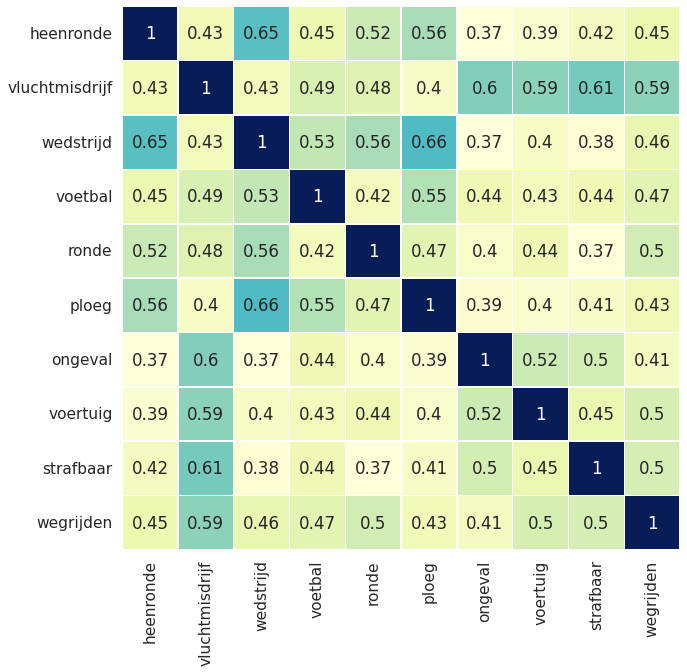

In [ ]:
# Calculates heatmap for given matrix.
sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(10,10))  
mat = calculateCosineMatrix(dfTotal.head(10))
dfMat = pd.DataFrame(mat, columns = dfinput.head(10)['Woord'].tolist())
cbar_kws = {"orientation":"horizontal", 
            "drawedges":True,
           }
sns.heatmap(dfMat, annot=True, linewidths=.5, ax = ax, cmap="YlGnBu", yticklabels = dfinput.head(10)['Woord'].tolist(), cbar_kws = cbar_kws, cbar=False)

In [ ]:
import numpy as np
from sympy.utilities.iterables import multiset_permutations

# Returns unit vector.
def unit_vector(vec):
    return vec / np.linalg.norm(vec)

# Returns cosine similarity between two vectors.
def cos_sim(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

# Returns SAME association between target words and attribute set.
def SAME_association(W, A):
    sum = 0
    for i in A:
      x = unit_vector(i)
      sum = sum + x
    A = A/np.linalg.norm(A)
    frac = 1/np.linalg.norm(A)
    return cos_sim(W, sum) * frac

# Normalizes the vectors of given attribute set.
def SAME_normalized_vectors(A):
    sum = 0
    for i in A:
      x = unit_vector(i)
      sum = sum + x
    A = A/np.linalg.norm(A)
    frac = 1/np.linalg.norm(A)
    return sum * frac

# Returns SAME association between target words and attribute sets A1 & A2.
def SAME_differential_association(W, A1, A2):
    return cos_sim(W, SAME_normalized_vectors(A1) - SAME_normalized_vectors(A2))

In [ ]:
# Used to retrieve SAME scores.

npTest = dfTotal.to_numpy()
#print(npTest)
#SAME_association(npTest[1], npTest[3])
print(SAME_differential_association(npTest[0], npTest[2:6], npTest[6:10]))
print(SAME_differential_association(npTest[0], npTest[2:6], npTest[10:14]))
print(SAME_differential_association(npTest[0], npTest[2:6], npTest[14:18]))
print(SAME_differential_association(npTest[1], npTest[2:6], npTest[6:10]))
print(SAME_differential_association(npTest[1], npTest[2:6], npTest[10:14]))
print(SAME_differential_association(npTest[1], npTest[2:6], npTest[14:18]))
print(SAME_association(npTest[0], npTest[2:6]))
print(SAME_association(npTest[1], npTest[2:6]))

0.21624556343643386
0.19173862418345855
0.27555121745325173
-0.22995658653258433
0.05237028777151953
0.1463989203461583
0.676992849799442
0.5583769355413096
